# Abstract

describe high-level aims of the analysis and an overview of the findings. No more than 1 paragraph.

First, we'll load the palmer penguins dataset:

In [76]:
import pandas as pd

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(url)

We'll take a quick peek at how the data looks:

In [77]:
train.head(5)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


# Data Preparation

To format the data into what we want, we'll have to do a few things. First, we'll get rid of the columns that won't help us predict the species of the penguin, in this case: "studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", and "Region". 



In [78]:
train = train.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)

The "Sex" column includes a third sex titled "." in the data that we will remove. We'll also remove any rows with missing data.

In [79]:
train = train[train["Sex"] != "."]
train = train.dropna()

Lastly, we'll convert all our categorical data into numerical data. For our target variable, "Species", we'll use a label encoder. This will assign each label a whole number. For the other columns, we will use one-hot encoding using `pandas.get_dummies` on our dataframe. This will create a new column for each unique value in the column. Our function `prepare_data` will return X_train, the training data without the target variable, and y_train, the training target variable.

In [80]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = 1*pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

Now our data looks like this:

In [81]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,0,1,0,1,0,1,1,0
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,0,1,0,1,0,1,0,1
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,1,0,0,1,0,1,0,1
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,1,0,0,1,0,1,1,0
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,0,1,0,1,0,1,0,1


We can see it's all numerical data now, with many categories containing binary data. Time to explore!

## Explore

2 interesting visualizations and 1 summary table visualization and table should:

1. Include axis labels and legends
2. help you draw conclusions about what features you are going to try using for your model
be accompanied by a discussion of what you learned and how you will use it in modeling. most figures and tables are worth at least one short paragraph of discussion.

Explain the following table:

In [82]:
X_train.groupby(["Sex_MALE", "Sex_FEMALE"]).aggregate(["mean"])

,,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes
,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Sex_MALE,Sex_FEMALE,,,,,,,,,,,,
0,1,42.562121,16.362121,198.189394,3887.500000,8.679350,-25.637225,0.492424,0.386364,0.121212,1.0,0.128788,0.871212
1,0,45.621774,17.950806,204.209677,4545.362903,8.815592,-25.680676,0.483871,0.370968,0.145161,1.0,0.088710,0.911290


Explain the following visualization:

<Axes: xlabel='Culmen Length (mm)', ylabel='Culmen Depth (mm)'>

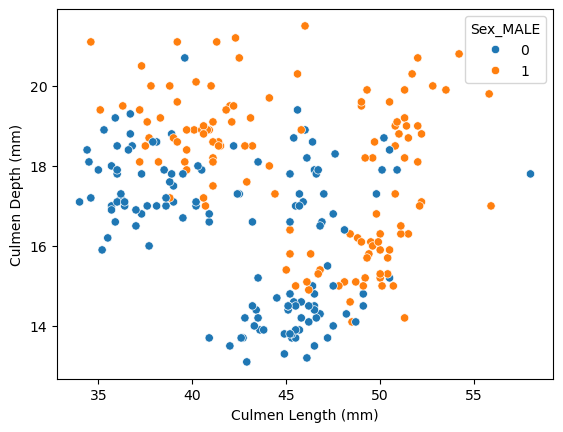

In [83]:
import seaborn as sns

categories = ["Body Mass (g)", "Culmen Length (mm)"]
sns.scatterplot(X_train, x = "Culmen Length (mm)", y = "Culmen Depth (mm)", hue = "Sex_MALE")


Explain the following visualization:

<Axes: >

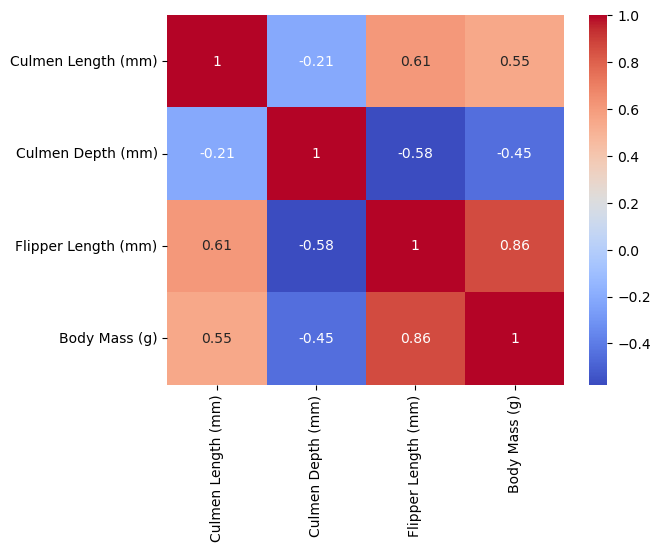

In [84]:
corr = X_train[["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')


The following scatterplot shows the relationship between **Culmen Depth (mm)** on the X-axis and **Body Mass (g)** on the Y-axis. The scatterplot is colored by the sex of the penguin, with purple representing female and orange representing male. This scatterplot shows two distinct clusters of penguins, one in the upper left and the other bottom right. Since we have color-coded by gender, we can see that the clusters are not separated by gender! Perhaps the are separated by Species, in which case this relationship will be very important when creating a classification model.

<Axes: xlabel='Culmen Depth (mm)', ylabel='Body Mass (g)'>

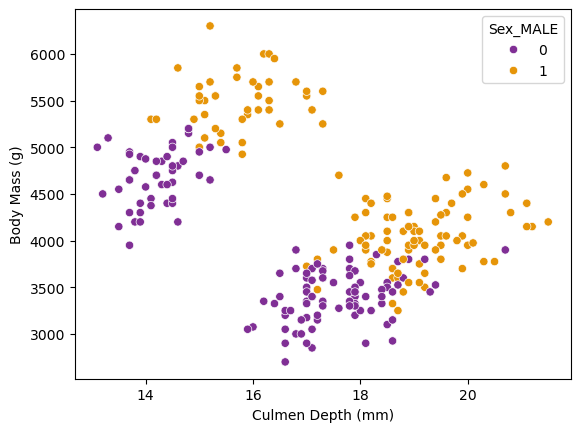

In [85]:
sns.scatterplot(X_train, x="Culmen Depth (mm)", y="Body Mass (g)", hue="Sex_MALE", palette="CMRmap")

# Discussion

Summarize findings and describe what you learned from the process of completing this post